<a href="https://colab.research.google.com/github/Josep-at-work/curso-series-temporales/blob/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/3_Trabajando_con_series_de_tiempo_en_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading and Transforming the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/MaddoSaru/curso-series-temporales/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/Index2018.csv") 
raw_csv_data = pd.read_csv("/content/drive/MyDrive/Udemy/Series Temporales/Data/telemetry.csv")
df_comp = raw_csv_data.copy()

In [16]:
m1 = df_comp[df_comp.machineID == 1]
m1.date = pd.to_datetime(m1.datetime, dayfirst = True)
m1.set_index("datetime", inplace=True)
m1 = m1.asfreq('h')
m1 = m1.fillna(method='ffill') # forward filling
m1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511




### Removing Surplus Data & Split

In [18]:
m1['metric'] = m1.vibration

In [19]:
del m1['volt']
del m1['rotate']
del m1['pressure']
del m1['vibration']
del m1['machineID']
size = int(len(m1)*0.8)
df, df_test = m1.iloc[:size], m1.iloc[size:]
df.head()

This far, is the same process from Notebook 2. Now we are going to add some white noise to the ts.

### White Noise

In order to have a white noise similar to the actual ts, we give to the white noise the mean and std of the ts.

In [21]:
wn = np.random.normal(loc = df.metric.mean(), scale = df.metric.std(), size = len(df)) 

In [22]:
df['wn'] = wn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
df.describe()

,machineID,metric,wn
count,7008.0,7008.000000,7008.000000
mean,1.0,40.557636,40.494865
std,0.0,5.559914,5.512645
min,1.0,22.666865,19.667115
25%,1.0,36.845363,36.763217
50%,1.0,40.317477,40.474769
75%,1.0,43.946342,44.252921
max,1.0,67.633435,61.441841


Note that count, mean and std are roughly the same.

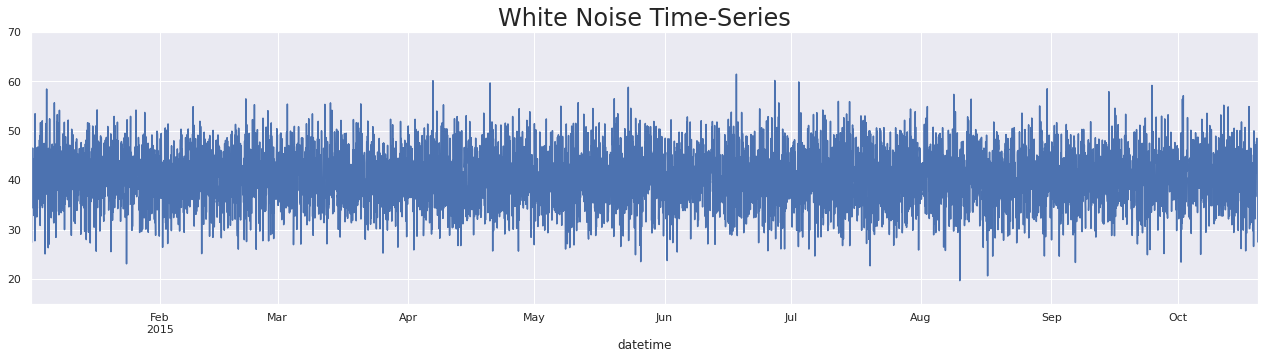

In [30]:
df.wn.plot(figsize = (22,5))
plt.title("White Noise Time-Series", size= 24)
plt.ylim(15,70)
plt.show()

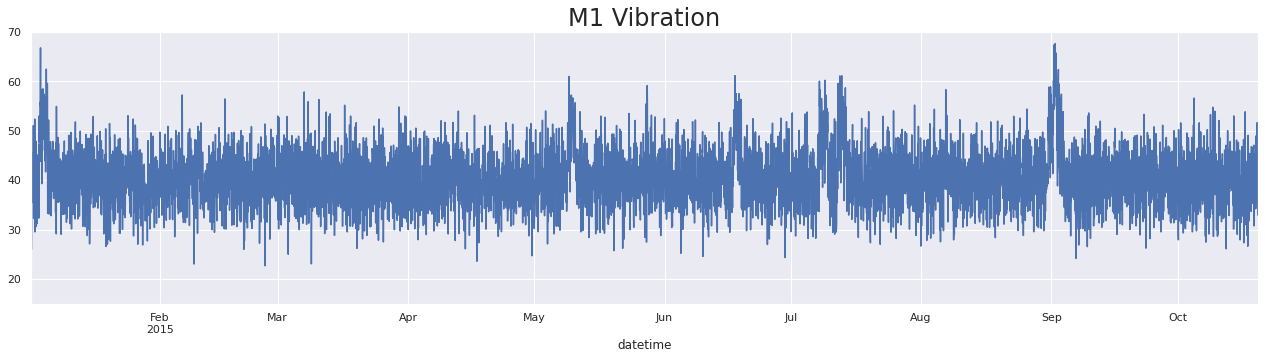

In [32]:
df.metric.plot(figsize=(22,5))
plt.title("M1 Vibration", size = 24)
plt.ylim(15,70)
plt.show()

In order to compare both series it's important to set the **same scale** (ylim).

Note that the vibration have a **white noise behaviour** in the majority of the periods, yet there are some **trends of shy hops** repeted over time. 

Q: 
+ What does those changes mean? Was there an error or failure of M1 
+ What happens with the other metrics at the same time?
+ Is there any clue in the previous datapoints which can make as know when this alterations will happen again? (This last would only be interesting if we find out that and those alteration mean some kind of error or failure of the machine)


### Random Walk

This time, the example dataset is specific for the market price data so I can't compare it with my data.

In [34]:
# rw = pd.read_csv("RandWalk.csv")
rw = pd.read_csv("https://raw.githubusercontent.com/Josep-at-work/curso-series-temporales/master/3.%20Caracter%C3%ADsticas%20fundamentales/Python/RandWalk.csv")

In [35]:
rw.head()

,date,price
0,07/01/1994,1122.139662
1,08/01/1994,1135.238562
2,09/01/1994,1109.897831
3,10/01/1994,1080.347860
4,11/01/1994,1082.095245


In [37]:
rw.date = pd.to_datetime(rw.date, dayfirst = True)


In [38]:
rw.set_index("date", inplace = True)


In [39]:
rw.head()

,price
date,
1994-01-07,1122.139662
1994-01-08,1135.238562
1994-01-09,1109.897831
1994-01-10,1080.347860
1994-01-11,1082.095245


In [43]:
rw = rw.asfreq("b")
rw.head()

,price
date,
1994-01-07,1122.139662
1994-01-10,1080.347860
1994-01-11,1082.095245
1994-01-12,1083.639265
1994-01-13,1067.146255


In [44]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [ ]:
df['rw'] = rw.price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1136.938032,1122.139662
1994-01-10,475.27,798.119160,1080.347860
1994-01-11,474.13,908.672286,1082.095245
1994-01-12,474.17,555.414796,1083.639265
1994-01-13,472.47,1451.393321,1067.146255


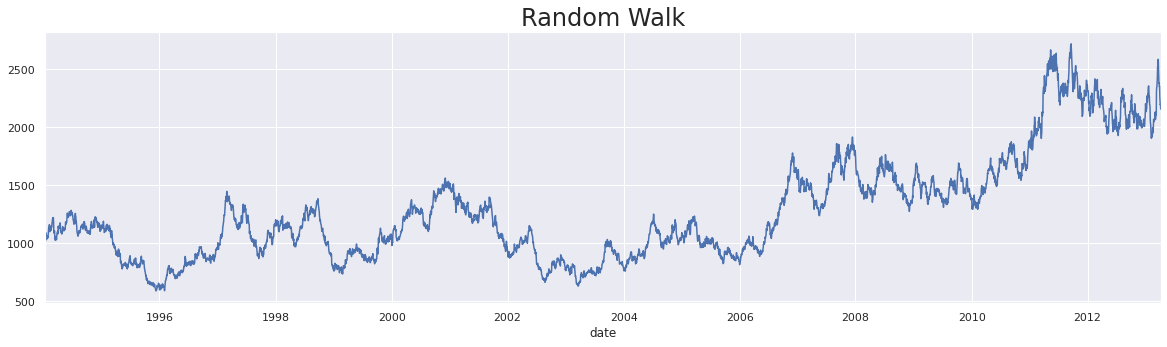

In [ ]:
df.rw.plot(figsize = (20,5))
plt.title("Random Walk", size = 24)
plt.show()

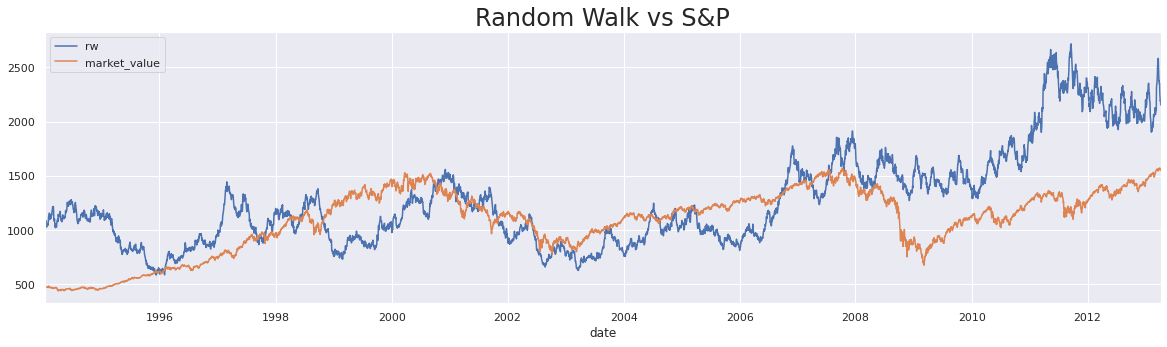

In [ ]:
df.rw.plot(figsize = (20,5))
df.market_value.plot()
plt.title("Random Walk vs S&P", size = 24)
plt.legend() 
plt.show()

### Stationarity

In [ ]:
sts.adfuller(df.market_value)

(-1.736984745235244,
 0.41216456967706194,
 18,
 5002,
 {'1%': -3.431658008603046,
  '10%': -2.567077669247375,
  '5%': -2.862117998412982},
 39904.880607487445)

In [ ]:
sts.adfuller(df.wn)

(-69.43972849152433,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '10%': -2.5670765656497516,
  '5%': -2.8621159253018247},
 70827.67556232118)

In [ ]:
sts.adfuller(df.rw)


(-1.3286073927689708,
 0.6159849181617388,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '10%': -2.567078038881065,
  '5%': -2.8621186927706463},
 46299.333497595144)

### Seasonality

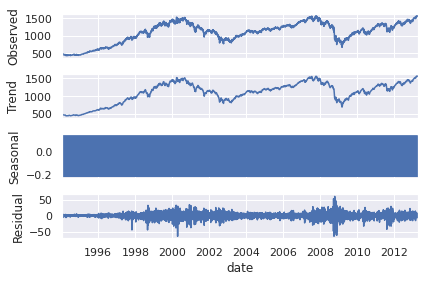

In [ ]:
s_dec_additive = seasonal_decompose(df.market_value, model = "additive")
s_dec_additive.plot()
plt.show()

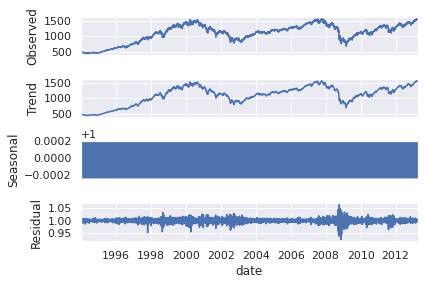

In [ ]:
s_dec_multiplicative = seasonal_decompose(df.market_value, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

### ACF

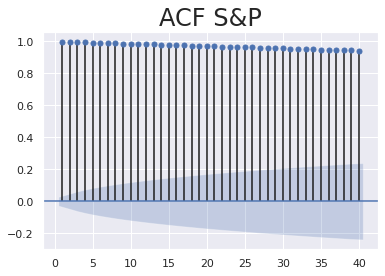

In [ ]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title("ACF S&P", size = 24)
plt.show()

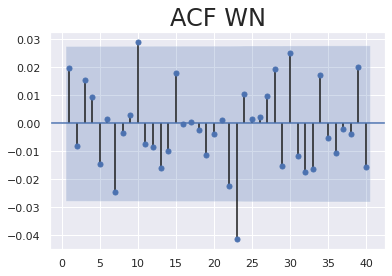

In [ ]:
sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title("ACF WN", size = 24)
plt.show()

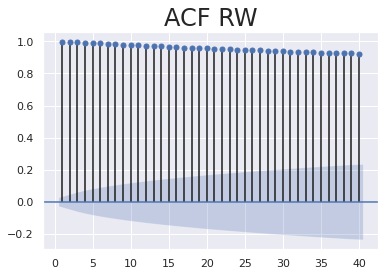

In [ ]:
sgt.plot_acf(df.rw, lags = 40, zero = False)
plt.title("ACF RW", size = 24)
plt.show()

### PACF

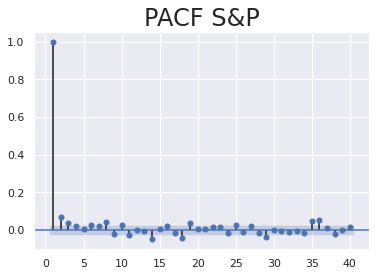

In [ ]:
sgt.plot_pacf(df.market_value, lags = 40, zero = False, method = ('ols'))
plt.title("PACF S&P", size = 24)
plt.show()

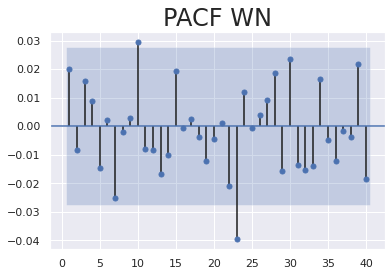

In [ ]:
sgt.plot_pacf(df.wn, lags = 40, zero = False, method = ('ols'))
plt.title("PACF WN", size = 24)
plt.show()

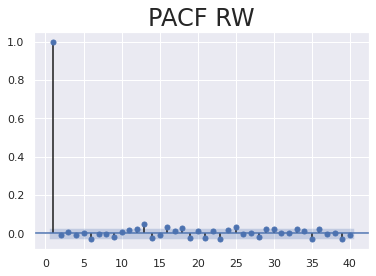

In [ ]:
sgt.plot_pacf(df.rw, lags = 40, zero = False, method = ('ols'))
plt.title("PACF RW", size = 24)
plt.show()